In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from emnist import get_emnist_data_loaders
train_loader, val_loader = get_emnist_data_loaders()

In [20]:
from models.crnn.crnn import CRNN
from models.lstm_cnn.lstm_cnn import CNN_LSTM
import torch.nn as nn
from training.trainer import Trainer
import hyperparameter as hp
import torch

crnn = CRNN(hp.GRU_HIDDEN_SIZE, hp.GRU_NUM_LAYERS, hp.NUM_CLASSES, hp.CNN_OUTPUT_HEIGHT)
lstm = CNN_LSTM(hp.GRU_HIDDEN_SIZE, hp.GRU_NUM_LAYERS, hp.NUM_CLASSES, hp.CNN_OUTPUT_HEIGHT)

models = {
    "CRNN": crnn,
    "CNN_LSTM": lstm
}

crnn_criterion = nn.CTCLoss(blank=hp.BLANK_LABEL, reduction='mean', zero_infinity=True)
lstm_criterion = nn.CTCLoss(blank=hp.BLANK_LABEL, reduction='mean', zero_infinity=True)

criterions = {
    "CRNN": crnn_criterion,
    "CNN_LSTM": lstm_criterion
}

crnn_optimizer = torch.optim.Adam(crnn.parameters(), lr=hp.LEARNING_RATE)
lstm_optimizer = torch.optim.Adam(lstm.parameters(), lr=hp.LEARNING_RATE)

optimizers = {
    "CRNN": crnn_optimizer,
    "CNN_LSTM": lstm_optimizer
}

crnn_trainer = Trainer(models["CRNN"], criterions["CRNN"], optimizers["CRNN"], train_loader, val_loader, hp.EPOCHS, {
        "blank_label": hp.BLANK_LABEL,
        "cnn_output_width": hp.CNN_OUTPUT_WIDTH,
    })
lstm_trainer =  Trainer(models["CNN_LSTM"], criterions["CNN_LSTM"], optimizers["CNN_LSTM"], train_loader, val_loader, hp.EPOCHS, {
        "blank_label": hp.BLANK_LABEL,
        "cnn_output_width": hp.CNN_OUTPUT_WIDTH,
    })
trainers = {
    # "CRNN": crnn_trainer,
    "CNN_LSTM": lstm_trainer
}


metrics_global = {}
for model_name, trainer in trainers.items():
    print(f"Training {model_name}")
    metrics = trainer.train_validate_test()
    metrics_global[model_name] = metrics
    print(f"Finished training {model_name}")

Training CNN_LSTM
100%|██████████| 125/125 [00:38<00:00,  3.22it/s]
EPOCH 1/10 - TRAINING. Correct: 0/8000 = 0.0000 - Average CER Score: 0.999
100%|██████████| 2000/2000 [00:09<00:00, 207.96it/s]
EPOCH 1/10 - TESTING. Correct: 0/2000 = 0.0000 - Average CER Score: 1.0
100%|██████████| 125/125 [00:42<00:00,  2.94it/s]
EPOCH 2/10 - TRAINING. Correct: 0/8000 = 0.0000 - Average CER Score: 0.994
100%|██████████| 2000/2000 [00:09<00:00, 208.57it/s]
EPOCH 2/10 - TESTING. Correct: 0/2000 = 0.0000 - Average CER Score: 0.917
100%|██████████| 125/125 [00:40<00:00,  3.06it/s]
EPOCH 3/10 - TRAINING. Correct: 3955/8000 = 0.4944 - Average CER Score: 0.744
100%|██████████| 2000/2000 [00:09<00:00, 209.60it/s]
EPOCH 3/10 - TESTING. Correct: 1486/2000 = 0.7430 - Average CER Score: 0.637
100%|██████████| 125/125 [00:41<00:00,  3.04it/s]
EPOCH 4/10 - TRAINING. Correct: 6491/8000 = 0.8114 - Average CER Score: 0.571
100%|██████████| 2000/2000 [00:09<00:00, 202.78it/s]
EPOCH 4/10 - TESTING. Correct: 1686/2000 

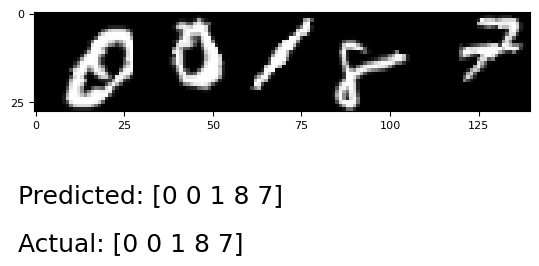

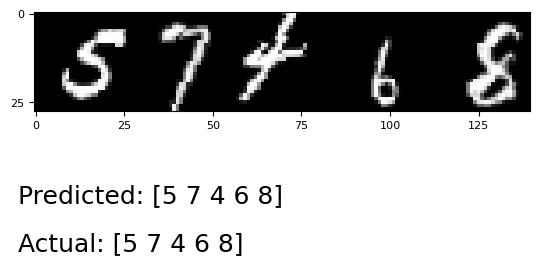

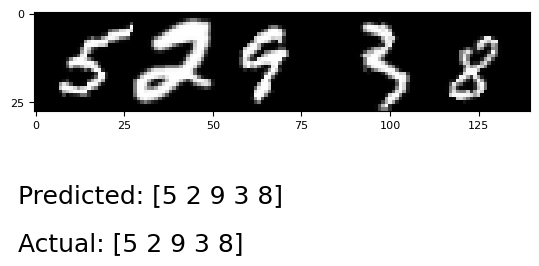

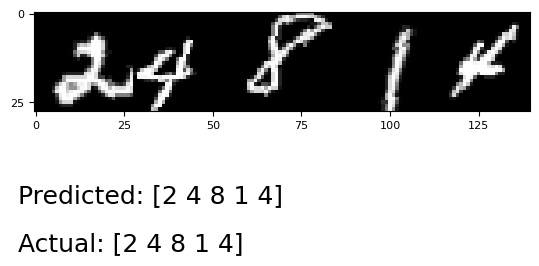

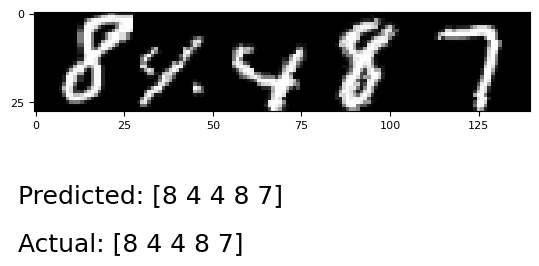

In [21]:

# ============================================ TESTING =================================================================
from matplotlib import pyplot as plt

number_of_test_imgs = 5
test_preds = []
(x_test, y_test) = next(iter(train_loader))
y_pred = trainer.model(x_test.view(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2]))
y_pred = y_pred.permute(1, 0, 2)
_, max_index = torch.max(y_pred, dim=2)
for i in range(x_test.shape[0]):
    raw_prediction = list(max_index[:, i].detach().cpu().numpy())
    prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != hp.BLANK_LABEL])
    test_preds.append(prediction)

for j in range(len(x_test)):
    if j == number_of_test_imgs:
        break

    mpl.rcParams["font.size"] = 8
    plt.imshow(x_test[j], cmap='gray')
    mpl.rcParams["font.size"] = 18
    plt.gcf().text(x=0.1, y=0.1, s="Actual: " + str(y_test[j].numpy()))
    plt.gcf().text(x=0.1, y=0.2, s="Predicted: " + str(test_preds[j].numpy()))
    plt.show()